In [311]:
import ants
import numpy as np
from dipy.tracking.streamline import *
from dipy.io.streamline import *
from dipy.tracking.utils import *
from scipy.io import loadmat, savemat
import nibabel as nib
import nibabel.streamlines as nis
import matplotlib.pyplot as plt
from dipy.tracking.metrics import *

In [376]:
file = '/Users/mahdi/stage-2022-mahdi/niftis/tracts/avgt_wildtype_tractogram.trk'
streamlines, hdr = load_tractogram(filename=file)

In [431]:
print(hdr)

{'magic_number': b'TRACK', 'dimensions': array([164, 212, 158], dtype=int16), 'voxel_sizes': array([ 0.06999999,  0.06999999,  0.06999999], dtype=float32), 'origin': array([ 0.,  0.,  0.], dtype=float32), 'nb_scalars_per_point': 0, 'scalar_name': array([b'', b'', b'', b'', b'', b'', b'', b'', b'', b''], 
      dtype='|S20'), 'nb_properties_per_streamline': 0, 'property_name': array([b'', b'', b'', b'', b'', b'', b'', b'', b'', b''], 
      dtype='|S20'), 'voxel_to_rasmm': array([[ 0.06999999,  0.        ,  0.        , -5.67500019],
       [ 0.        ,  0.06999999,  0.        , -8.79448032],
       [ 0.        ,  0.        ,  0.06999999, -8.45033455],
       [ 0.        ,  0.        ,  0.        ,  1.        ]], dtype=float32), 'reserved': b'', 'voxel_order': b'RAS', 'pad2': b'', 'image_orientation_patient': array([ 0.,  0.,  0.,  0.,  0.,  0.], dtype=float32), 'pad1': b'', 'invert_x': b'', 'invert_y': b'', 'invert_z': b'', 'swap_xy': b'', 'swap_yz': b'', 'swap_zx': b'', 'nb_streamline

## Fiber lengths histogram

In [ ]:
length(streamlines)

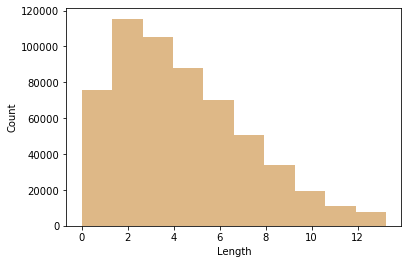

In [377]:
lengths = list(length(streamlines))

fig_hist, ax = plt.subplots(1)
ax.hist(lengths, color='burlywood')
ax.set_xlabel('Length')
ax.set_ylabel('Count')
plt.show()

## Fiber from a ROI mask

In [378]:
roi_file = "/Users/mahdi/stage-2022-mahdi/niftis/485847695_180403712_25_0.07/485847695_180403712_x-rois_mask_25_0.07.nii.gz"
mask = nib.load(roi_file)

In [379]:
nearby_roi = near_roi(
    streamlines=streamlines,
    affine=mask.affine,
    region_of_interest=mask.get_fdata()
    )

In [380]:
print(nearby_roi.shape)

(577555,)


In [381]:
streamlines_near_roi = []
for i in range(len(streamlines)):
    if nearby_roi[i]:
        streamlines_near_roi.append(streamlines[i])   


In [401]:
save_tractogram(
    fname="/Users/mahdi/stage-2022-mahdi/niftis/tracts/near_roi.trk",
    streamlines=streamlines_near_roi,
    affine=np.eye(4),
    header=hdr
    )

## Fiber from sphere and radius (entry coords)

In [384]:
def draw_spherical_mask(shape, radius, center):
    """
    Generate an n-dimensional spherical mask.

    Parameters
    ----------
    shape: tuple
        Shape of the volume created.
    radius: int/float
        Radius of the spherical mask.
    center: tuple
        Position of the center of the spherical mask.

    Return
    ------
    ndarray: Volume containing the spherical mask.
    """
    # Assuming shape and center have the same length and contain ints
    # (the units are pixels / voxels (px for short),
    # radius is a int or float in px)
    assert len(center) == len(shape)
    semisizes = (radius,) * len(shape)

    # Generating the grid for the support points
    # centered at the position indicated by center
    grid = [slice(-x0, dim - x0) for x0, dim in zip(center, shape)]
    center = np.ogrid[grid]

    # Calculating the distance of all points from center
    # scaled by the radius
    vol = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(center, semisizes):
        vol += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return vol <= 1.0

In [385]:
sphere = draw_spherical_mask(
    shape=mask.shape,
    radius=1,
    center=(68, 128, 66)
).astype(np.float32)

In [386]:
through_sphere = near_roi(
    streamlines=streamlines,
    affine=mask.affine,
    region_of_interest=sphere
    )

In [387]:
print(through_sphere.shape)

(577555,)


In [388]:
streamlines_in_sphere = []
for i in range(len(streamlines)):
    if through_sphere[i]:
        streamlines_in_sphere.append(streamlines[i])   

In [400]:
save_tractogram(
    fname="/Users/mahdi/stage-2022-mahdi/niftis/tracts/in_sphere.trk",
    streamlines=streamlines_in_sphere,
    affine=np.eye(4),
    header=hdr
    )

In [ ]:
print(load_tractogram("/Users/mahdi/stage-2022-mahdi/niftis/tracts/near_roi.trk")[1])

## Gradient

In [329]:
def compute_gradient_streamline(streamline):
    return np.gradient(streamline)

In [330]:
def compute_gradient_bundle(bundle):
    gradients = []
    for streamline in bundle:
        gradients.append(
            compute_gradient_streamline(streamline))
    return gradients

In [332]:
gradients = compute_gradient_bundle(streamlines_in_sphere)

## Orientation inside roi

In [258]:
print(mean_orientation(streamlines_near_roi[7894]))

[ 0.05695901 -0.04966164 -0.03916985]


In [260]:
import math

In [271]:
def compute_direction(vector):
    x, y, z = vector[0], vector[1], vector[2]
    return math.atan(math.sqrt((z**2)/(x**2 + y**2))) * 180/math.pi

In [292]:
def compute_direction_per_point(streamline):
    directions = []
    for vector in streamline:
        directions.append(compute_direction(vector))
    return directions

In [272]:
print(compute_direction(streamlines_near_roi[7894][0]))

62.10526317010092


In [293]:
directions_in_roi = []
for s in streamlines_near_roi:
    directions_in_roi.append(compute_direction_per_point(s))

In [302]:
print(directions_in_roi[7894])

[62.10526317010092, 62.5051749373461, 62.84207687817745, 62.71125484534937, 62.271408863389304, 61.77459306214649, 61.22330196441009, 60.60909569348748, 59.877004248986545, 59.20629832142198, 58.45090629964322, 57.8718035710309]


In [ ]:
n,bins,_ = plt.hist(np.array(directions_in_roi).ravel(),bins=20)
plt.xlabel("degré",fontsize=14)
plt.ylabel("nombre d'orientations",fontsize=14)
xs = np.arange(len(n))
ymax = np.array(n).max()
for x in xs:
    if(n[x]==np.array(n).max().all()):
        xmax = bins[x]
plt.annotate('max',xy=(xmax,ymax),xytext=(xmax-50,ymax+ymax/20),arrowprops=dict(facecolor='black',shrink=0.01))

cf plot

c'est faux.... c'est des points ici non des vecteurs

## HOG

In [129]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
from PIL import Image

In [146]:
image = Image.open("/Users/mahdi/Desktop/img_rapport/Capture d’écran 2022-05-03 à 17.19.51.png")

In [320]:
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

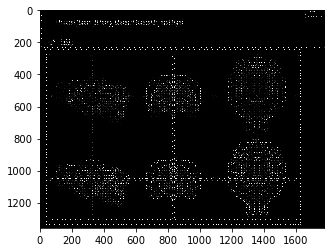

In [321]:
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)

## ODF

In [373]:
from dipy.data import read_stanford_labels
from dipy.reconst.csdeconv import auto_response
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

In [403]:
# response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)
# csa_model = CsaOdfModel(gtab, sh_order=6)
# csa_peaks = peaks_from_model(csa_model, data, default_sphere,
#                              relative_peak_threshold=.8,
#                              min_separation_angle=45,
#                              mask=sphere)

## bval bvecs ?

## some metrics in dipy

In [404]:
curvature = mean_curvature(streamlines_in_sphere[5654])

In [405]:
print(curvature)

1.0766


In [409]:
orientation = mean_orientation(streamlines_in_sphere[5654])

In [410]:
print(orientation)

[ 0.06999087 -0.02729972  0.01197381]


In [411]:
longest_track = longest_track_bundle(streamlines_in_sphere)

In [427]:
print(length(streamlines_in_sphere[5654]))

10.8547


In [428]:
from dipy.data import read_stanford_hardi

In [429]:
from dipy.core.gradients import gradient_table
from dipy.io import read_bvals_bvecs

In [430]:
import dipy.reconst.dti as dti

In [ ]:
dti.TensorModel()